# Introduction to Sentiment Analysis: Identifying and Mapping Disinformation Campaigns using NLP

*Module adapted from UBC COMET, prepared originally by Anneke Dresselhuis and Irene Berezin, by Irene Berezin, Anna Kovtunenko, Jalen Faddick and the prAxIs UBC team.*

## Disinformation in the Information Age

**Disinformation** is defined as being deliberately false information, created with the intention to mislead it's reader. Disinformation has been weaponized since the early middle ages: for example, in the 19th century, New Ywork-based newspaper *The Sun* published a series of articles, about the discovery of life on the Moon, with the purpose of increasing sales of *The Sun*. The papers claimed that, using a massive telescope, an english astronomer had discovered vegetation, bipedal beavers, and human-like aliens, dubbed "man-bats", that were four feet tall, had wings, and could fly (Zielinski, 2015). Whether-or-not the *great Moon Hoax* lead to *The Sun* becoming a successfull paper remains uncertain; some accounts claim that the series of papers brought *The Sun* to international fame, however it's likely that rumors of *The Sun*'s hoax increasing the paper's circulation were exaggerated. 

<div style="display: flex; align-items: flex-start; gap: 1em;">

  <div style="flex: 0 0 500px;">
    <img 
      src="soci_270_images/disinformation_example_1.png" 
      alt="An example of disinformation spread on twitter urnign voters to vote via twitter" 
      style="width: 100%; height: auto; display: block;">
  </div>

  <div style="flex: 0 0 500px;">
    <img 
      src="soci_270_images/muller_report_1.png" 
      alt="Middle example" 
      style="width: 100%; height: auto; display: block;">
  </div>

</div>
     
This is an example of a (mostly) harmless disinformation campaign; However, disinformation campaigns can, and have, been used instead to sway public opinion on critical matters. For example, during the Cold War, the KGB orchestrated a widespread disinformation campaign, alledging that HIV/AIDs was a bioeapon engineedred by the United States, in an effort to stoke global mistrust of public health authorities and foster anti-americanism (Selvage & Nehring, 2019). A particularly relevant example is political elections: State-sponsored Russian actors have mounted disinformation campaigns in ever single US federal election since 2016, at the latest. In 2016, for instance, the Russian state-sponsored Internet Research Agency (IRA) ran hundreds of facebook and Twitter groups that amplified divisive content, and organized astroturf rallies in key US states, most notably Pennsylvania (Menn and Dave, 2018). The extent to which these coordinated campains influenced the 2016 United-States election remains unclear: initial findings by the DOJ suggested that Russia coordinated a sweeping, large scale multi-million dollar online campaign aimed to praise Donald Trump and disparage Hillary Clinton (Muller, 2019). However, multiple studies have found that even under generous assumptions about presuasion rates, the vote-shifts caused by the IRA's disinformation campaigns were too small to sway the election's outcome (Allcot & Gentzkow, 2017, Eady et al., 2023). 

With the rise of digital platforms and generative AI, the scale, speed, and sophistication of disinformation have grown exponentially. From elections and pandemics to social justice movements and international conflicts, false or misleading content is being spread online to manipulate emotions and polarize public opinion. The challenge today is not just the volume of disinformation, but how convincing and targeted it has become. Former U.S. Director of National Intelligence Avril Haines describes how state-sponsored campaigns, like Russia’s Kremlin, now operate using “a vast multimedia influence apparatus,” including bots, cyber-actors, fake news websites, and social media trolls. **Large language models (LLMs)** can now generate human-like tweets, comments, and articles at scale. Combined with deepfakes, doppelgänger sites, and AI-generated personas, these tools allow bad actors to craft propaganda that appears authentic, emotionally resonant, and difficult to detect.


In this notebook, we’ll use machine learning — specifically, pretrained large language models — to study the language of disinformation in a real dataset of English and Russian-language tweets. These tweets include both propagandist and non-propagandist content.

## Learning Outcomes
By the end of this module, you will be able to better understand disinformation and propaganda techniques using the following computational tools:

- **Sentiment analysis** to detect emotional tone (positive, negative, neutral)
- **Toxicity analysis** to identify harmful or aggressive language (e.g., insults, threats)
- **Statistical testing** to compare patterns between tweet types and languages (e.g., English vs. Russian)

You'll learn how to work with pretrained LLMs, interpret model predictions, and use basic statistical methods to answer questions like:

- Are propagandist tweets more emotionally charged or toxic than normal political tweets?
- Do they use different rhetorical strategies in different languages?
- Can we identify signals that indicate a tweet is part of a disinformation campaign?

Through this analysis, we’ll explore various dimmensions of AI applications, critically examining how it can be used to better understand and detect the patterns of disinformation when working with large amounts of social data.

## Key Terms and Concepts

**Disinformation:** Disinformation is generally understood as the *intentional* spreading of false, misleading, or incorrect information, in order to influence the public or create an outcome, usually political.

**Propaganda:** Propaganda is similar to disinformation in it's intent to spread a cause or doctrine, but can differ in how systematically or overtly it is speread. The two concepts are both forms of misinformation, with propaganda generally being employed to promote a cause.

**Large Language Model (LLM):** A Large Language Model is a langauge model trained on a very large set of text data, accessing the features of the text by converting units of text into quanitative representations that can be used for various tasks, such as chatbotting, or in the case of this notebook, Natural Language Processing.

**Natural Language Processing (NLP):** Natural Langauge Processing encompasses a wide variety of techniques and practices wtih the goal of enabling computers to understand, interpret, and produce human language. The key NLP techniques in this notebook are *sentiment analysis*, a technique that analayzes the relative positivity or negativity of langauge, and *toxitcity analyis* which analyzes the relative aggressiveness of language.

**BERT:** to enable these analyses we will be using two BERT models. BERT is an open-source framework for machine learning, whcih is used for NLP. BERT is well-suited to understanding langauge, rather than generating it, which is what this notebook is concerned with. The specific BERT models we are using are a multi-lingual [model](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2), which can analyze tweets in different languages, and a [model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) trained for analyzing tweet sentiments.

**Fine Tuning:** The multi-lingual model is fine-tuned, or trained specifically on the Russian Disinformation tweet dataset. This is done by inputting a training subset of the data, where the tweets are labeled as Disinformation, into the BERT model to create a model familiar with our data, and well-suited to producing analyses.



## Dataset

Our data for this notebook comes from four sources:

### 1) The analysis data: 
The data used from our analysis is a combination of four datasets: 
1) The Russian troll tweets dataset, AKA the Internet Research Agency (IRA) tweets dataset is a large, verified collection of social media posts created by the Internet Research agency, the Russian state-sponsored troll farm we talked about earlier. The data was collected and provided by FiveThirtyEight (RIP) an America political news website that focused on providing detailed statistical analyses of the political climate in the United States. Compared to other russian troll datasets, IRA dataset is unparalleled in terms of accuracy as because the data labels were directly provided by Twitter's internal security teams, which identified the IRA troll accounts and turned over to the United States Congress as evidence for the Senate Select Committee on Intelligence's investigation into foreign election interference. Hence, every single tweet in the dataset is a known, verified russian disinformation account. 
2) The sentiment140 dataset is a massive english language datasets of tweets, created by Standford with the purpose of training sentiment analysis detection models. This dataset serves as our english control group. 
3) Likewise, theRusentimental dataset is a dataset of modern-day Russian tweets, collected by Russian NLP researchers for sentiment analysis purposes. This serves as our Russian control group. 
4) Lastly, we added tweets taken from a collection of known russian disinformation accounts that were active during the start of the Russia-Ukraine War. Researchers selected these tweets based on the accounts' "association with state-backed media and a history of spreading disinformation and misinformation".

### 2) The model training data:

For our analysis, we trained a **tweet propaganda detection model** off of the paper "Labeled Datasets for Research on Information Operations", which provides the same verified collection of disinformation accounts from the IRA, as well as a "control" dataset of legitimate, topically-related accounts, which allowed for a direct, comparative analysis between malicious and organic online posts, within the same conversational political context. To avoid including training data in our in-class analysis, the IRA dataset was randomly split in two, with one half being used for model training and the other half being used for the in-class demo.


![](soci_270_images/datasets_explainer.png)


# 0. Preliminary data analysis 

In order to get started using machine learning to map disinformation campaigns, we need to set our machines up to be able to:

1. Open and interpret the dataset.
2. Visualize key aspects of the data.
3. Access a pre-trained machine learning model that can be used on our data.

To do this, we are using the `import` statement which allows us to access the functions and capabilities of each module. The modules we are using allow us to complete differenet tasks. We will use Python to do communicate which capabilities we want to use and we will continue writing in Python to use these capabilities. It is what we are using to communicate what libraries or capabilities we want to use. We will learn more about what each module is doing as we continue to use them.

In [53]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import os
from pathlib import Path

from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import datar
from datar.dplyr import glimpse
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency


In [1]:
from data_pulling import create_disinformation_dataset

Now that we have successfully accessed all of the functions we need to carry out our disinformation investigation, we can start to look into the data we are working with. We are going to be using the `pandas` library, which is a popular tool to read and handle data. Note that our data needs to be pulled off of the internet for us to use first. For this, we will need two seperate API keys, one for Kaggle, and one for GitHub.

Follow the setup instructions here:
1) https://www.kaggle.com/docs/api (read only the paragraphs under `authentication`)
2) For GitHub, create a new API key here: https://github.com/settings/tokens. When pulling data, you'll be prompted to enter your credentials (GitHub username, and GitHub PAT instead of password)

Once that's done, run the code below to pull and generate our dataset:

In [2]:
create_disinformation_dataset() #creates our dataset

skipping
skipping
skipping
downloaded kaggle datasets
skipping, data there already
downloaded github repo
fixed dates
fixed dates
fixed dates
fixed dates
done


In [64]:
tweets = pd.read_csv('C:/Users/Irene/testrepo/praxis-ubc/soci_270/data/combined_disinformation_dataset_final.csv') #loads in the dataset for us to use
tweets = tweets[['language', 'date', 'time', 'source', 'is_propaganda', 'content']]
print(tweets.columns) # the columns we chose to keep for our analysis

Index(['language', 'date', 'time', 'source', 'is_propaganda', 'content'], dtype='object')


Let's take a look at the dataset together. Recall that our dataset is comprised of four different datasets. Use the drop-down menu below to take a glimpse at the data for each of the four datasets. What do you notice? 

In [ ]:
unique_categories = ['All'] + sorted([str(cat) for cat in tweets['source'].unique().tolist()])


category_dropdown = widgets.Dropdown(
    options=unique_categories,
    value='All',
    description='Source dataset:',
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

output = widgets.Output()
def filter_by_category(change):
    selected_category = change['new']
    with output:
        clear_output(wait=True)
        if selected_category == 'All':
            display(tweets)
        else:
            filtered_df = tweets[tweets['source'].astype(str) == selected_category]
            display(filtered_df)

category_dropdown.observe(filter_by_category, names='value')
display(category_dropdown, output)
filter_by_category({'new': 'All'})

Dropdown(description='Source dataset:', layout=Layout(width='400px'), options=('All', 'IRA', 'RuSentitweet', '…

Output()

To continue exploring the data, we are going to take a look at tweets that are labeled as control tweets, meaning they are not Russian disinformation. These tweets just come from the posts of regular users. These posts are not necessarily apolitical, or without an attempt to persuade; however, they do not meet the dataset's criteria of disinformation. 

Take a look at a few of the characteristics of the tweets below, looking at both the text of the tweets and the data associated with each post. Some of the tweets look very similar to each other. Look through the tweet metadata and examine if any of the other characteristics of the posts are similar. 

Think about what you might be able to infer from each user based on their posts, and the metadata available to us in this dataset. Consider what is missing from this picture as well. What data might be unavailable to us, and how does it limit our picture of these users. While you are building a picture of the Twitter user (their beliefs, intent, history, posting time, etc.), list a couple reasons why you believe these users were not flagged as disinformation. 

In [11]:
category_dropdown = widgets.Dropdown(options=[0, 1], value=1,  description='Filter by Label:',style={'description_width': 'initial'}, layout={'width': '400px'})
pd.options.display.max_colwidth = None
output = widgets.Output()

def filter_by_label(change):
    selected_label = change['new']
    with output:
        clear_output(wait=True)
        filtered_text = tweets[tweets['is_propaganda'] == selected_label]['content']
        display(filtered_text)

category_dropdown.observe(filter_by_label, names='value')
display(category_dropdown, output)

filter_by_label({'new': category_dropdown.value})


Dropdown(description='Filter by Label:', index=1, layout=Layout(width='400px'), options=(0, 1), style=Descript…

Output()

For now, let's focus solely on the propagandist dataset: Recall that the tweets here originate from two seperate datasets-- one from known propagandist accounts active around and before the 2016 US presidential election, and one from known propagandist accounts discovered during the start of the Russia-Ukraine war in 2022. 

There are many ways we can represent the posting activity visually. In this graph, we visualize the posting activity weekly over the course of a decade. It is important to select a scale appropriate for the amount of data we are working with, especially if that data spans a wide range. Here, we are using a log scale on the y-axis (the number of posts).

> A Log (or logarithmic) scale is a way to represent data which spans large numerical ranges, and makes it easier to visualize and interpret data that changes dramatically. 

As you look at the graph pay close attention to the following:

1. General trends in activity. Does either type of tweet increase over time? Is there any stagnation? Which years had the most weekly overall activity?

2. Which years stick out as being exceptionally different. Consider some key events from those years. If nothing comes to mind immediately, do a quick search for top news topics of those years in your browser.

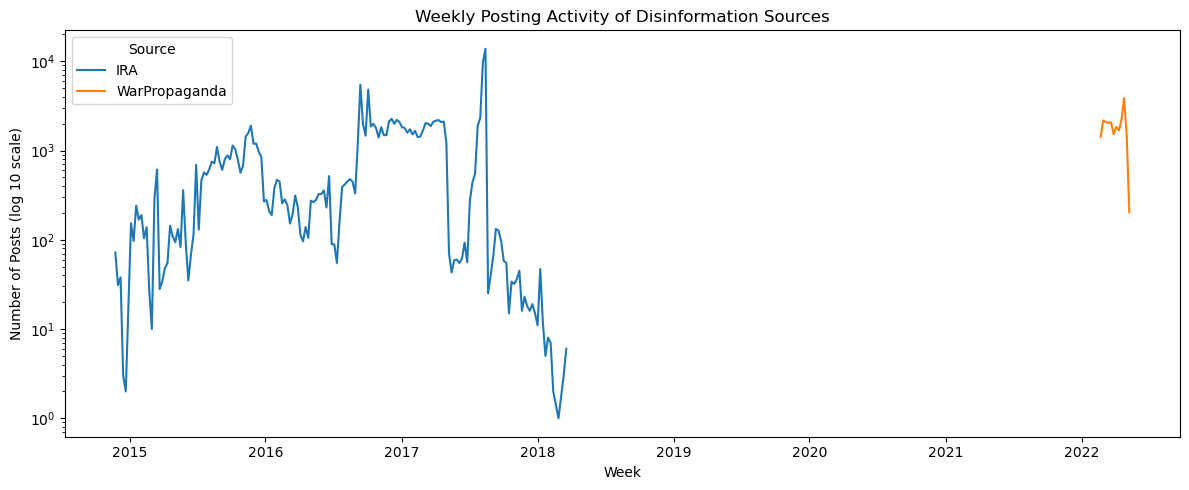

In [12]:
propaganda_df = tweets[tweets['is_propaganda'] == 1].copy()
propaganda_df['date'] = pd.to_datetime(propaganda_df['date'], errors='coerce')
propaganda_df.dropna(subset=['date'], inplace=True)
propaganda_df['week'] = propaganda_df['date'].dt.to_period('W')
weekly_counts = propaganda_df.groupby(['week', 'source']).size().reset_index(name='count')
weekly_counts['week'] = weekly_counts['week'].dt.to_timestamp()


plt.figure(figsize=(12, 5))
sns.lineplot(data=weekly_counts, x='week', y='count', hue='source')
plt.yscale('log', base=10) #scaled log10. Remove this and see how the visualization changes!

plt.title("Weekly Posting Activity of Disinformation Sources")
plt.xlabel("Week")
plt.ylabel("Number of Posts (log 10 scale)") 
plt.legend(title="Source")
plt.tight_layout()
plt.show()


Another aspect of our data we can look at is the characteristics of the text itself. How are the tweets originating from the IRA Dataset and the tweets originating from the 2022 War Propaganda Dataset different? Are they the same length? Do they discuss the same topics? What language(s) are the tweets in? 

Textual information like this act as clues to give us information about who the target audience of these tweets is, and what propagandist messages are specifically being spread. 

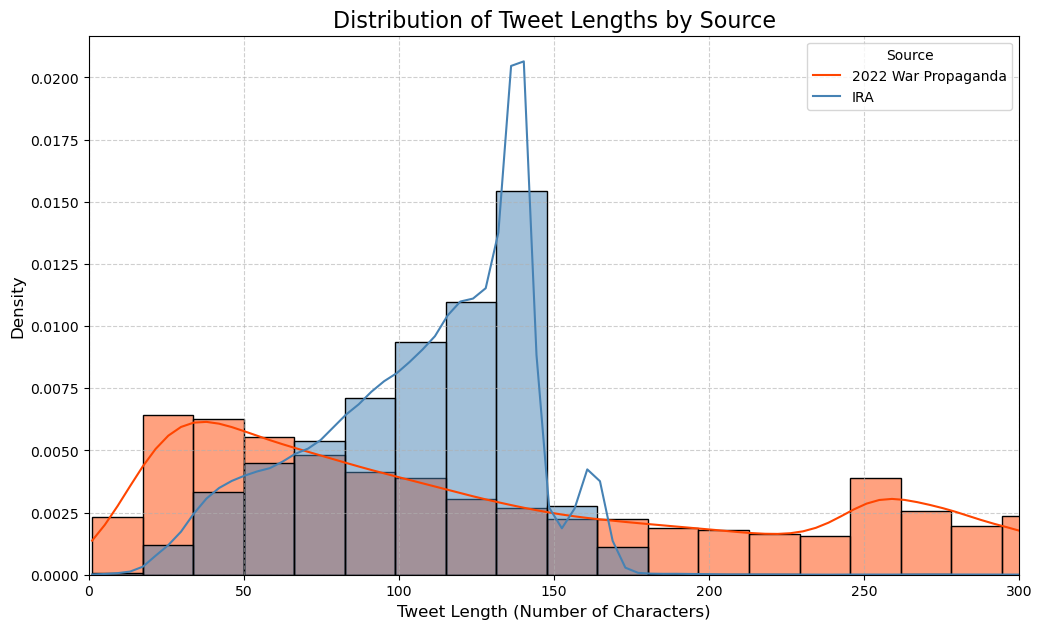

In [13]:
propaganda_df = tweets[(tweets['is_propaganda'] == 1) & (tweets['content'].notna())].copy()
propaganda_df['tweet_length'] = propaganda_df['content'].str.len()

plt.figure(figsize=(12, 7))
sns.histplot(data=propaganda_df, x='tweet_length', hue='source', 
             kde=True, common_norm=False, stat='density',
             bins=50, palette={'IRA': 'steelblue', 'WarPropaganda': 'orangered'})

plt.title('Distribution of Tweet Lengths by Source', fontsize=16)
plt.xlabel('Tweet Length (Number of Characters)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, 300) # The majority of tweets are under 280 characters
plt.legend(title='Source', labels=['2022 War Propaganda', 'IRA'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Consider the graph above. It shows us the distribution of tweet length across the 2022 War Propaganda Dataset (red) and IRA Dataset (blue). Why do you think both datasets have bimodal (i.e. two peaks) distributions? Look at the data to tease out the relationship between length and tweet types. 

Another aspect of the text we could look at is the types of words that appear the most frequently in each dataset. What do you notice? 

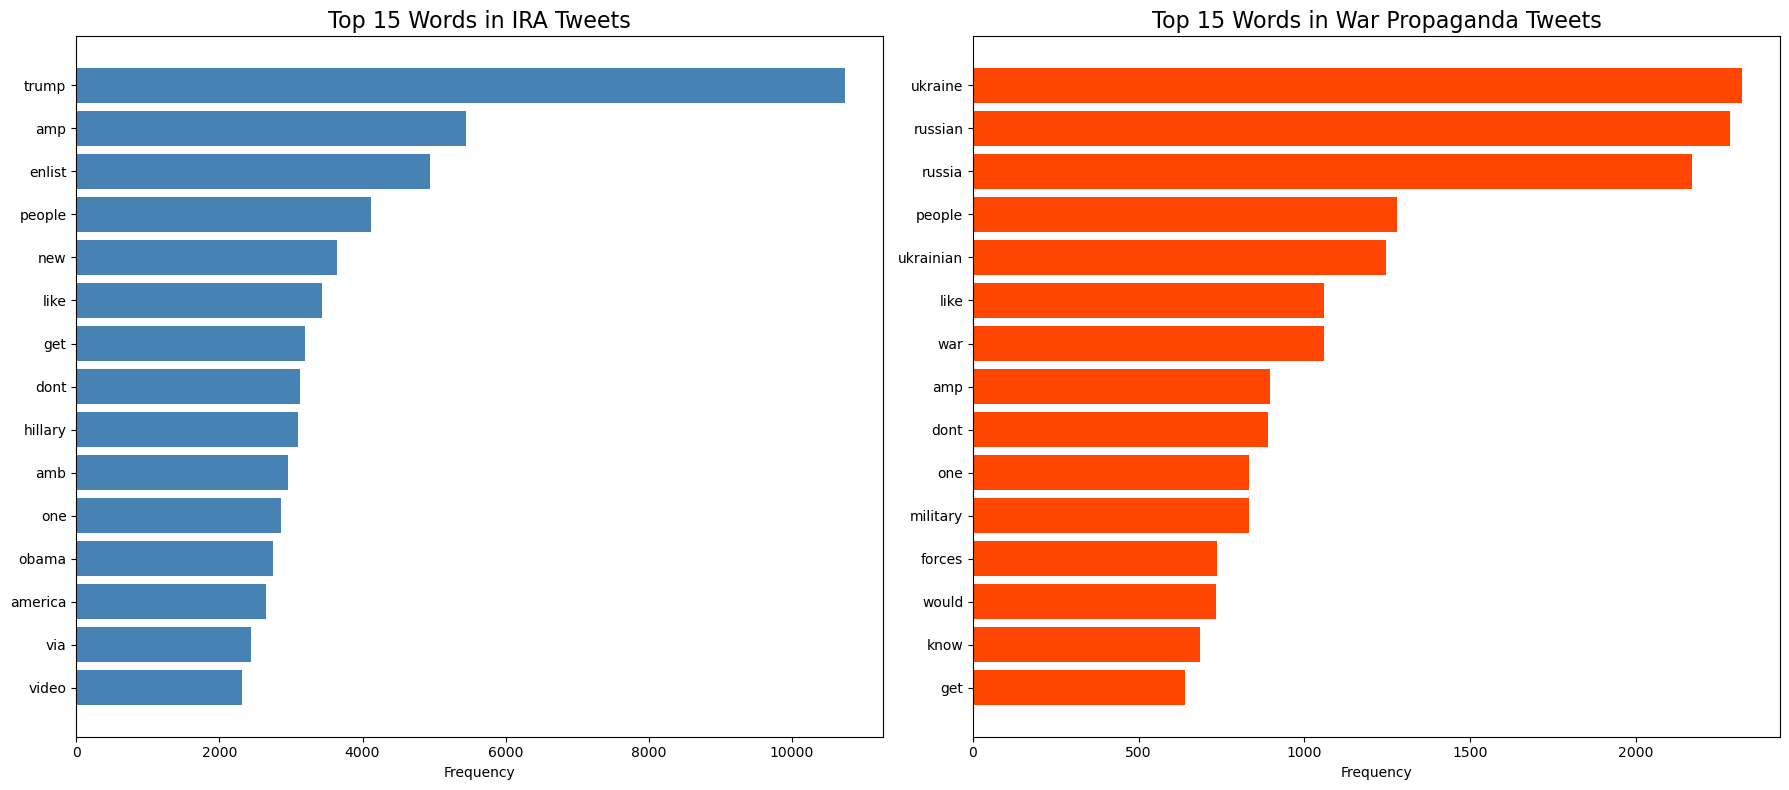

In [14]:
stop_words = set(stopwords.words('english'))

def clean_text_and_get_words(text):
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\@\w+|\#','', text) 
    text = re.sub(r'[^\w\s]','', text) 
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return words

ira_words = propaganda_df[propaganda_df['source'] == 'IRA']['content'].dropna().apply(clean_text_and_get_words)
war_words = propaganda_df[propaganda_df['source'] == 'WarPropaganda']['content'].dropna().apply(clean_text_and_get_words)

ira_top_words = Counter([word for sublist in ira_words for word in sublist]).most_common(15)
war_top_words = Counter([word for sublist in war_words for word in sublist]).most_common(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.barh(*zip(*reversed(ira_top_words)), color='steelblue')
ax1.set_title('Top 15 Words in IRA Tweets', fontsize=16)
ax1.set_xlabel('Frequency')

ax2.barh(*zip(*reversed(war_top_words)), color='orangered')
ax2.set_title('Top 15 Words in War Propaganda Tweets', fontsize=16)
ax2.set_xlabel('Frequency')

plt.tight_layout()
plt.show()

After filtering out some additional common, insignicant words (called 'stopwords' in NLP, consider words like "the", "a", and "is"), we can look at the same question using word clouds. In word clouds, the larger the word, the more frequently it appears within a given subset of the dataset.


![](soci_270_images/wordclouds.png)

Another dimmension we could look at with this data is the posting activity of  control vs. disinformation tweets over the course of the day. Note that the tweets were all originally collected in UTC, which we changed to PST.

🧠 **Key Questions:** 

- Consider why each account is posting at different times.
- Is there a meaningingful difference in who posts when? Why might that be?
- Is there anything surprising to you about the tweet volume at each hour? 

Think about some possible explanations for the trends in the data and consider whether it confirms or challenges your assumptions about how and when disinformation is produced. Why are both the IRA and sentiment140 datasets so consistent across time, whereas the 2022 War Propaganda dataset experiences considerable dips in posting activity over the course of 24 hours? Hint: Think about what time zone's sleep schedule this would correspond to. 


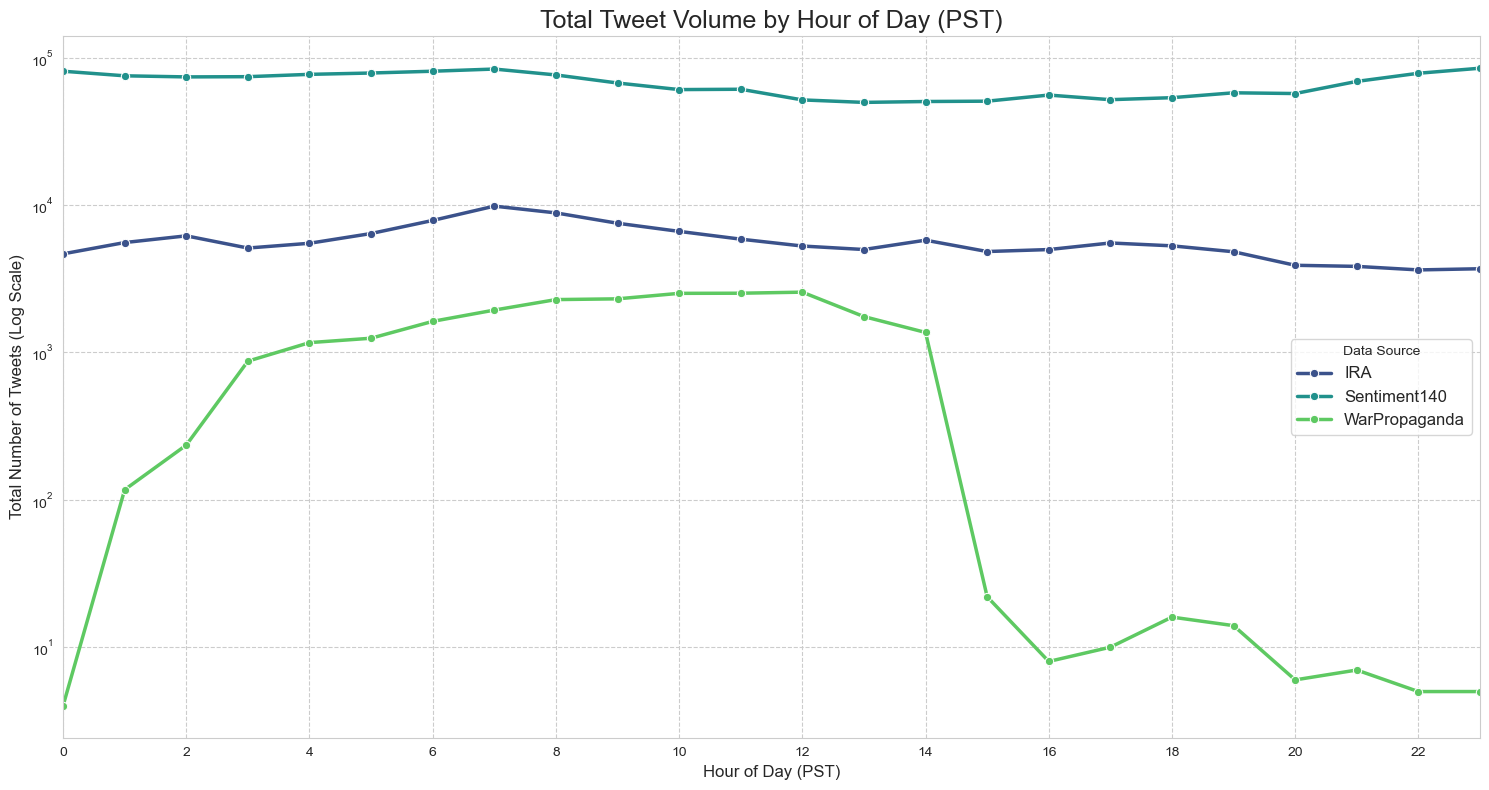

In [26]:
tweets['datetime_utc'] = pd.to_datetime(
    tweets['date'].astype(str) + ' ' + tweets['time'].astype(str), 
    errors='coerce'
)

tweets.dropna(subset=['datetime_utc'], inplace=True)
tweets['datetime_pst'] = tweets['datetime_utc'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
tweets['hour'] = tweets['datetime_pst'].dt.hour
hourly_totals = tweets.groupby(['source', 'hour']).size().reset_index(name='count')

sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.figure(figsize=(15, 8))

sns.lineplot(data=hourly_totals, x='hour', y='count', hue='source', palette='viridis', linewidth=2.5, marker='o', markersize=6)

plt.yscale('log')
plt.title('Total Tweet Volume by Hour of Day (PST)', fontsize=18)
plt.xlabel('Hour of Day (PST)', fontsize=12)
plt.ylabel('Total Number of Tweets (Log Scale)', fontsize=12)
plt.xticks(range(0, 24, 2))
plt.xlim(0, 23)
plt.legend(title='Data Source', fontsize=12)
plt.tight_layout()
plt.show()

 

>⏪ **Callback**
>
>Remember when we first examined the features of our data, the total number of disinformation posts was significantly higher than the number of control posts? That difference in volume is represented graphically below with the greater average number of posts from disinformation accounts. It is important to recognize that this is just a feature of our dataset, and is not necessarily representative of all the posts on Twitter at that time. Nevertheless, there are some important features of this visualization that we need to consider. 

As you look over the graph, try to answer the following questions:

1. Why are disinformation accounts posting early in the morning and late at night? What might they be trying to acheive with such an aggressive posting schedule.
2. Think about your own social media posting. When do you usually post? Is this reflected by the Control curve?
3. Additionally, think about when you are on social media. What hours are you most frequently looking at content? 

>📱 **Activity**
>
>If you freuqently use social media, take a look at you screen activity in your devices settings and look at the hours you frequently use social media applications. If you don't have social media, find a partner who's comfortable sharing their data with you and compare the hours of usage to the posting activity of the Disinformation accounts and the Control accounts. 
>

Does your usage align or differ from the activity of the accounts in our dataset?


## 0.1 Hashtag analysis

What hashtags are being used in tweets from propagandist vs. non-propagandist accounts? For the next part of our data analysis, we’ll find the freqency of the 10 most common hashtags used by the two account types. As you explore the tables below, notice the content and language of the hashtags. 

Our earlier language analysis suggests that most disinformation in this dataset is likely in English. By examining the hashtags used in these tweets, we can better understand the specific words, topics, and narratives that disinformation accounts are trying to amplify.

To begin, we’ll extract hashtags from our textual data by finding phrases beginning with the character #, and ignoring hashtags shorter than 10 letters for the sake of making things interesting.

In [31]:
tweets['content'] = tweets['content'].astype(str) # because some of the tweets aren't strings, apparently
def extract_hashtags(text):
    return re.findall(r'#(\w+)', text.lower())


tweets['hashtags'] = tweets['content'].apply(extract_hashtags)
tweets['hashtags'] = tweets['hashtags'].apply(lambda hashtag_list: [tag for tag in hashtag_list if len(tag) > 10])

print(tweets[['is_propaganda', 'content', 'hashtags']].head())

   is_propaganda  \
0              1   
1              0   
2              0   
3              0   
4              0   

                                                                                                                                        content  \
0  #Hancock Co. #K9 honored by #PETA as hero #dog.  #Lucas: That's just what I do�  Love it! ��   http://t.co/IrhReleo8v http://t.co/zYflkYJke1   
1                                                                                        lonnggggggg day.... work, school &amp; then boyfriend    
2                                                   @Nelia23 I will try that  and maybe I should hide the heels or only use the glass flats LOL   
3                                                                                                  @Ohsotragical Random people always watching    
4        @MissErikaT im most likely not....unless i can find sumthin hella cheaper wit my bruhs which is prolly not gonna happen soooo....nope  

Now we can visualize the frequency of the 10 most common hashtags longer than 10 characters used by propagandist accounts over time. 

> ### 🔎 Engage Critically
> 
❓ **Key Questions**
> 
1. With reference to the timeline of tweets, and the hashtags below, describe some of the main targets of Russian disinformation. 
2. Given what you know about disinformation, what are the *intentions* of these accounts, and what *outcomes* are they attempting to create?
3. What do the hashtags *not* tell us about the disinformation accounts? Where might our ability to conclude the intentions and outcomes of these accounts be limited by the data we have examined?
4. What additional data could we collect to better understand this type of disinformation. 

C:\Users\Irene\AppData\Local\Temp\ipykernel_6596\956225383.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_prop_df['date'] = pd.to_datetime(top_prop_df['date'], errors='coerce')
C:\Users\Irene\AppData\Local\Temp\ipykernel_6596\956225383.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_prop_df.dropna(subset=['date'], inplace=True)


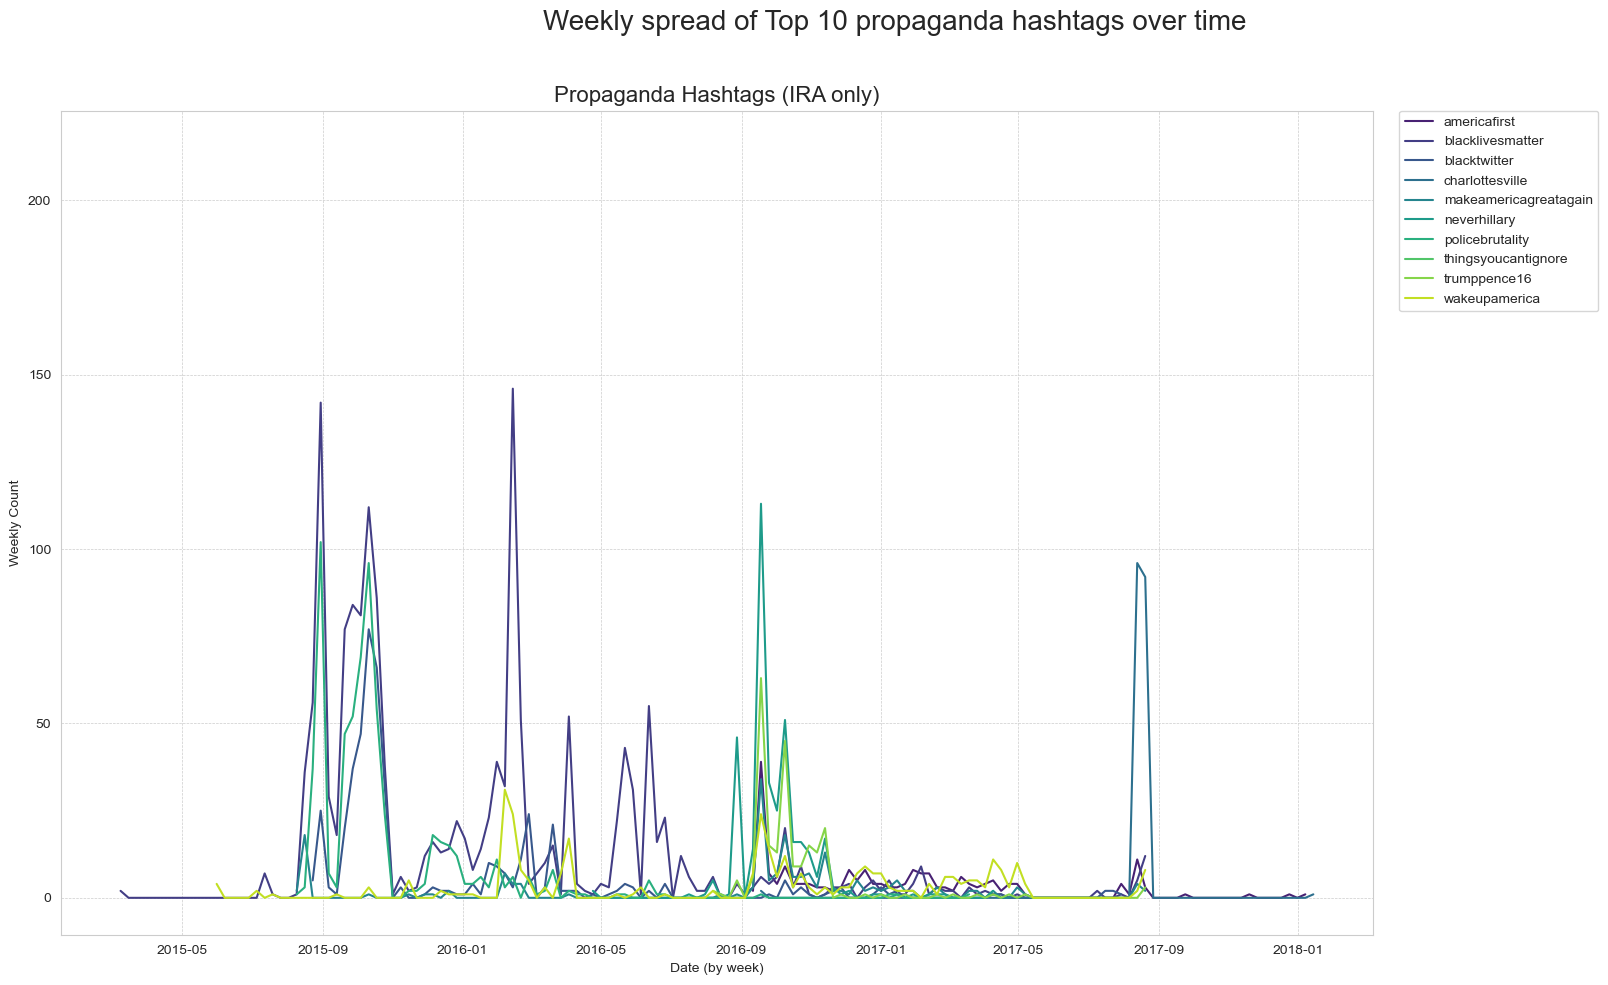

In [32]:
propaganda_tweets = tweets[tweets['is_propaganda'] == 1]
propaganda_hashtags = propaganda_tweets.explode('hashtags')
top_20_propaganda = propaganda_hashtags['hashtags'].value_counts().head(10)

top_prop_list = top_20_propaganda.index.tolist()
top_prop_df = propaganda_hashtags[propaganda_hashtags['hashtags'].isin(top_prop_list)]
top_prop_df['date'] = pd.to_datetime(top_prop_df['date'], errors='coerce')
top_prop_df.dropna(subset=['date'], inplace=True)

prop_weekly = top_prop_df.groupby('hashtags').resample('W', on='date').size().reset_index(name='count')

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
fig.suptitle('Weekly spread of Top 10 propaganda hashtags over time', fontsize=20)

sns.lineplot(ax=ax, data=prop_weekly, x='date', y='count', hue='hashtags', palette='viridis')
ax.set_title('Propaganda Hashtags (IRA only)', fontsize=16)
ax.set_xlabel('Date (by week)')
ax.set_ylabel('Weekly Count')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()

To explore how these hashtags trend over time, you can use the interactive tool below. Enter one or more hashtags (separated by commas) to visualize their weekly frequency in the dataset. This can help reveal how certain narratives gain momentum or fade in relevance.

In [37]:
all_hashtags_df = tweets.explode('hashtags')
all_hashtags_df['date'] = pd.to_datetime(all_hashtags_df['date'], errors='coerce')
all_hashtags_df.dropna(subset=['date', 'hashtags'], inplace=True)
all_hashtags_df['hashtags'] = all_hashtags_df['hashtags'].str.lower()

In [39]:

hashtag_input = widgets.Text(value='news,russia,syria',placeholder='Enter hashtags, separated by commas',description='Hashtags:',layout={'width': '50%'})

plot_output = widgets.Output()

def update_plot(change):
    hashtags_to_plot = [tag.strip().lower() for tag in change['new'].split(',') if tag.strip()]
    with plot_output:
        clear_output(wait=True)
        if not hashtags_to_plot:
            print("enter at least one hashtag")
            return
        filtered_data = all_hashtags_df[all_hashtags_df['hashtags'].isin(hashtags_to_plot)]

        if filtered_data.empty:
            print("No data found for the specified hashtags")
            return
        weekly_counts = filtered_data.groupby('hashtags').resample('W', on='date').size().reset_index(name='count')
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        sns.lineplot(data=weekly_counts, x='date', y='count', hue='hashtags', ax=ax)
        
        ax.set_title('Weekly Frequency of Selected Hashtags')
        ax.set_xlabel('Date')
        ax.set_ylabel('Weekly Mentions')
        ax.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

hashtag_input.observe(update_plot, names='value')

print("Enter a comma-separated list of hashtags to see their trends over time.")
display(widgets.VBox([hashtag_input, plot_output]))
update_plot({'new': hashtag_input.value})

Enter a comma-separated list of hashtags to see their trends over time.


### 🛑 Stop and Reflect ###

Now that we have gone through the dataset and examined a variety of its features, take a few minutes and disucss the following questions with a partner or small group. 

1. What are the conclusions we have come to regarding disinformation? How are they influenced or limited by the dataset? 
2. So far we have only looked at statistical aspects of the data without using machine learning techniques. Make some predictions on how the machine learning techniques we will use next might change our understanding of online disinformation. How might machine learning, specifically NLP be used to enrich our understanding of disinformation?
3. Has your understanding of online disinformation changed after looking at this data? Write down a few questions you have about online disinformation, the dataset, or the computational methods we have been using.

## 1. Can we tune models to detect online disinformation campaigns? Classifying current tweets with a model finetuned on the russian_disinformation_tweets dataset

### Exploring Our Model

Now that we have examined our data and looked at some of the key features in the Russian Disinformation Dataset, we can start thinking about ways to use machine learning to answer questions, classify features, and make predictions about our dataset. To do any of these tasks we first require a way to interpret the text data and assign numeric qualities to our tweets. 

The model we are using to do this is a multilingual model which maps sentences and paragraphs into multi-dimensional vector space. In other words, it takes the sentences and paragraphs of our tweets and assigns them a position associated with their meaning. This is done based on the context of the token (the unit of text, like a word or sentence). The model we are using is capable of interpreting multiple languages and is fine-tuned, or specifically trained, on the data we are examining. The code below is going to call upon a pre-built classifier which uses this fine-tuned model to predict whether a tweet is likely Russian propaganda. The two sample tweets are: 

1. “#qanon #trump Hunter Biden is a Ukranian Shill” 

2. “What great weather we have today” 

The model is going to take these text inputs, represent them in vector space, and then report whether their respective values are similar to those of disinformation tweets.  

### Classification and It's Discontents ### 

Before we explore the possibilities of our model to classify, we should first consider some of the main concerns and limitations regarding classification. Classification is an essential element of how machine learning operates. At its core it is the method of finding features that are central to a class and assigning units to that class based on those features. As you may already see, this "in-or-out" framework necessarily flattens some of the richness of human life, in order to effectively create these incredibly useful classes.

> **Example:** 
>
> You might say a cat and a dog are really easy to classify. Most people know what a dog looks like and that it looks different than a cat. But if all I tell you is that there are two animals that commonly live with humans, that have a tail and paws, and make noise you might have a hard time classifying them, because they share common features.
>
> It is important to think deeply about how we are classifying, especially as many datasets are labeled by people, who carry their own understandings of what belongs to each class.
>
> Any class or classifier will be informed by the balance of abstraction to specificity, and we should always keep this in mind when we are classifying. It is important to be specific enough to ascertain the qualities we are interested in, but not so specific we end up with thousands of classes.

Now that we have explored some of the trickiness of classification as a concept, we can look at how machine learning can help us work through some of these challenges. By using data that is labeled as disinformation our model can be trained to associated certain numerical feautres with disinformation, and when we give it text data that is similar to what it knows to be disinformation, it will classify it as such.

For this analysis, we trained a model on a dataset very similar to ours, with the purpose of detecting propaganda tweets. Recall, however, that this model was trained **soley on tweets around and before the 2016 presidential election- meaning it has never seen any tweets posted after this point**. Given this information, what kinds of tweets do you think the model will struggle with the most? What kinds of propaganda tweets will it excel at detecting? Try using the model below, and see if you can get it to label a string of text as disinformation.

In [40]:
classifier = pipeline("text-classification",model="IreneBerezin/soci-280-model")

print(classifier("crooked hillary is trying to rig the election! #MAGA!")) #put your text in here

Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.9877774119377136}]


Let's now apply the model to a random sample of the dataset we've been studying. How well do you think the model will perform?

In [41]:
tweets_sample = tweets.sample(n=2000, random_state=60)
tweets_inference = tweets_sample[["content", "is_propaganda"]].dropna()
tweets_inference['is_propaganda'] = 1 - tweets_inference['is_propaganda'] # for whatever reasons the labels are switched in the training data

classifier = pipeline("text-classification",model="IreneBerezin/soci-280-model",device=-1)
predictions = classifier(tweets_inference['content'].tolist(),batch_size=32,truncation=True)
predicted_labels = [int(p['label'].split('_')[1]) for p in predictions]
true_labels = tweets_inference['is_propaganda'].tolist()


Device set to use cpu


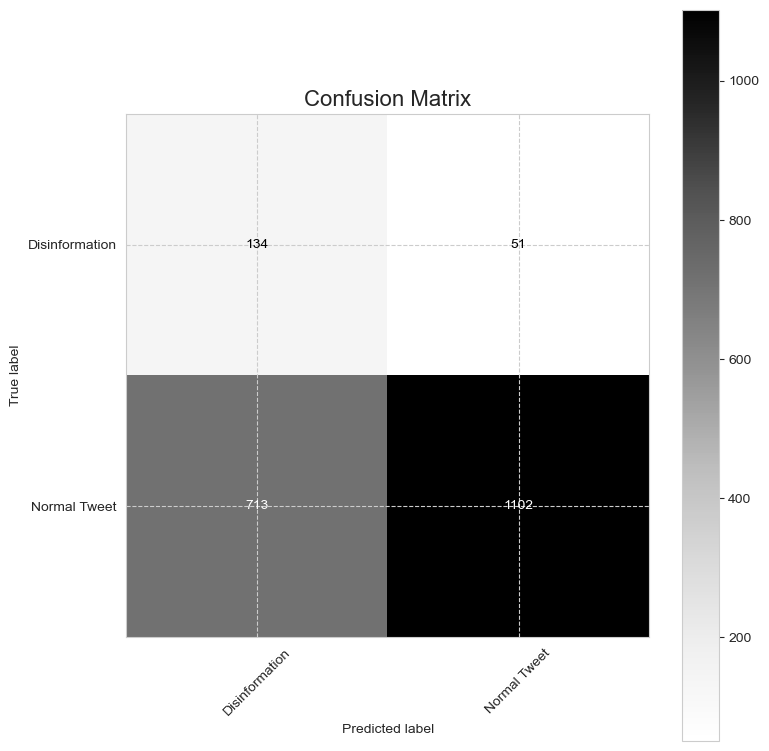

In [44]:

display_labels = ['Disinformation', 'Normal Tweet']

cm = confusion_matrix(y_true=true_labels,y_pred=predicted_labels,labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Confusion Matrix", fontsize=16)
disp.plot(ax=ax, cmap='Greys') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Pretty terribly, apparently! Above is what's called a **confusion matrix**: it shows the number of labels that were correctly predicted, and incorrectly predicted. We see that, out of a random sample of 2000 tweets:

- 797 tweets were marked as disinformation, and were, in fact, disinformation
- 504 tweets were labelled as normal tweets while they were, in fact, disinformation
- 282 tweets were labelled disinformation when they were in fact normal 
- 417 tweets were correctly labelled as normal tweets

So, better than blindly guessing (which would put us on average as 500 tweets in each category) but still very bad. 

This is an example of **overfitting**: instead of actually learning what constitutes a propagandist tweet, the model simply memorized the specific writing styles of the troll accounts present in the training set. Hence, when it was shown new tweets from different troll accounts in the test set, it failed, as it never learned the general patterns that define an account as part of a coordinated disinformation campaign. The model did the ML equivalent of memorizing in great detail all the solutions to questions in a math textbook instead of actually learning how to solve them.



## 1. What is Sentiment Analysis?
> “Sentiment analysis is the practice of applying natural language processing and text analysis techniques to identify and extract subjective information from text” (Hussein, 2018). 

As this definition alludes, sentiment analysis is a part of **natural language processing (NLP)**, a field at the intersection of human language and computation. Because humans are complex, emotional beings, the language we use is often shaped by our affective (emotional) dispositions. Sentiment analysis, sometimes referred to as “opinion mining”, is one way researchers can methodologically understand the emotional intentions, typically positive, negative, or neutral sentiments, that lie in textual datasets.

> ### 🔎 Engage Critically
> At the heart of sentiment analysis is the assumption that language reveals interior, affective states, and that these states can be codified and generalized to broader populations. AI scholar Kate Crawford, in her book [Atlas of AI](https://katecrawford.net/atlas), explores how many assumptions found in contemporary sentiment research (i.e., that there are 7 universal emotions) are largely unsubstantiated notions that emerged from mid-20th century research funded by the US Department of Defense. Rather than maintaining that emotions can be universally categorized, her work invites researchers to think about how emotional expression is highly contextualized by social and cultural factors and the distinct subject positions of content makers.
>
>> ❓ Consider the research question for your sentiment analysis. How might the text you are working with be shaped by the distinct groups that have generated it?
> 
>> ❓ Are there steps you can take to educate yourself around the unique language uses of your dataset (for example, directly speaking with someone from that group or learning from a qualified expert on the subject)?
> 
If you’re interested, you can learn more about data justice in community research in a [guide](https://orice.ubc.ca/wp-content/uploads/sites/43/2022/06/2022-Gender-Guide-1.pdf) created by UBC’s Office for Regional and International Community Engagement.

The rise of [web 2.0](https://en.wikipedia.org/wiki/Web_2.0) has produced prolific volumes of user-generated content (UGC) on the internet, particularly as people engage in a variety of social platforms and forums to share opinions, ideas and express themselves. Maybe you are interested in understanding how people feel about a particular political candidate by examining tweets around election time, or you wonder what people think about a particular bus route on reddit. UGC is often unstructured data, meaning that it isn’t organized in a recognizable way.

Structured data for opinions about a political candidate might look like this:

| Pro      | Con | Neutral    |
| ----------- | ----------- | -----------
| Supports climate action policies      | No plan for lowering the cost of living       | UBC Graduate
| Expand mental health services   |        |

While unstructured data might look like this:

> love that she’s trying to increase mental health services  + actually cares abt the climate 👏 but what's up w rent n grocieries?? i dont wanna go broke out here 😭 a ubc alum too like i thought she'd understand

In the structured data example above, the reviewer defines which parts of the feedback are positive, negative or neutral. In the unstructured example on the other hand, there are many typos and a given sentence might include a positive and a negative review as well as more nuanced contextual information (i.e. mentioning being a UBC alum when discussing cost of living). While messy, this contextual information often carries valuable insights that can be very useful for researchers.

The task of sentiment analysis is to make sense of these kinds of nuanced textual data - often for the purpose of understanding people, predicting human behaviour, or even in some cases, manipulating human behaviour.

Disinformation campaigns often aim to sway public opinion by influencing the emotional tone of online conversations. **Sentiment analysis** allows us to detect and understand these patterns by identifying whether large volumes of text express **positive**, **negative**, or **neutral** sentiment.

Our model is pretrained, meaning it has already learnt from millions of labelled examples how to distinguish different sentiments. Specifically, because the model we’ll be using was trained on English tweets, it’s tuned to the language and syntax common on Twitter/X, and is limited to analyzing English-language text.

**Language is complex and always changing.**

In the English language, for example, the word “present” has multiple meanings which could have positive, negative or neutral connotations. Further, a contemporary sentiment lexicon might code the word “miss” as being associated with negative or sad emotional experiences such as longing; if such a lexicon were applied to a 19th century novel which uses the word “miss” to describe single women, then, it might incorrectly associate negative sentiment where it shouldn’t be. While sentiment analysis can be a useful tool, it demands ongoing criticality and reflexivity from a researcher (you!). Throughout your analysis, be sure to continually ask yourself whether a particular sentiment lexicon is appropriate for your project.

Now, we're ready to get back to our analysis. Below, we'll load in our model and tokenizer and start playing around with identifying the sentiment of different phrases. 

In [45]:
sentiment = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

print(sentiment("I hate everyone and everything"))
print(sentiment("Life is great!"))
print(sentiment("Hello world"))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'label': 'negative', 'score': 0.9047315120697021}]
[{'label': 'positive', 'score': 0.9793545007705688}]
[{'label': 'positive', 'score': 0.6495164036750793}]


Let’s breakdown this output. There are two parts to what the model returns:

1. **Label** → a classification labelling the text as either having positive, negative, or neutral sentiment 
2. **Score** → the model’s confidence in it’s classification

> ### 🔎 Engage Critically
> Try using the interactive tool below to explore how a machine learning model detects sentiment in short texts like tweets. The model classifies each input as positive, neutral, or negative, and assigns a probability score to each label. Type a sentence (like a tweet or short message) into the box below and click "Analyze" to see how the model interprets its emotional tone.

In [ ]:
text_input = widgets.Text(
    value="hello world!",
    placeholder="Type a sentence here",
    description="Input:",
    layout=widgets.Layout(width="70%")
)
analyze_btn = widgets.Button(description="Analyze", button_style="primary")
output_area = widgets.Output()

def on_analyze_clicked(b):
    with output_area:
        clear_output(wait=True)
        scores = sentiment(text_input.value)
        labels = [item["label"] for item in scores]
        probs  = [item["score"] for item in scores]
        fig, ax = plt.subplots(figsize=(6,4))
        bars = ax.bar(labels, probs)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_title("Sentiment Probability Distribution")
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                height + 0.02,                    
                f"{prob:.2f}",                   
                ha="center", va="bottom",
                color="red", fontsize=12)
        plt.show()

analyze_btn.on_click(on_analyze_clicked)

display(widgets.VBox([text_input, analyze_btn, output_area]))

### Batch Sentiment Analysis

Now, let’s start running sentiment analysis on our dataset. The general steps to run our analysis include: 

1. Loading a pretrained model and tokenizer
    
    We load a RoBERTa model that has been fine-tuned for sentiment analysis on tweets, along with its corresponding tokenizer.
    
2. Creating sentiment analysis pipeline
    
    We set up a Hugging Face pipeline that handles finer steps in our sentiment analysis, such as **tokenization** (breaking up text into smaller units, called *tokens*), **batching** (processing multiple texts at once for efficiency), and **prediction** (predicting the overall sentiment). 
    
3. Running batch sentiment analysis on the dataset
    
    To efficiently analyze large numbers of tweets, we split the dataset into batches of 1,000 tweets and process them one batch at a time. To store the predictions, we extract the predicted sentiment labels and save them in a column named `sentiment`.

4. Previewing the results
    

In [66]:
tweets_small = tweets.groupby('source').sample(n=1000, random_state=42)
tweets_small = tweets_small.sample(frac=1, random_state=42).reset_index(drop=True) #you might want to change this value
tweets_small["sentiment"] = "" 

In [ ]:
batch_size = 1000
n = 0
for start in range(0, len(tweets_small), batch_size):
    end = start + batch_size
    batch_texts = tweets_small["content"].iloc[start:end].tolist()
    results = sentiment(batch_texts)           
    labels  = [res["label"] for res in results]
    tweets_small.loc[start:end-1, "sentiment"] = labels 
    n = n+1
    print(f'batch {n} done')

batch 1 done
batch 2 done


In [49]:
print(tweets_small[["content", "sentiment"]].head())

                                                                                                                      content  \
0        http://twitpic.com/6tpc0 - in the fiction life, this is my brother's scandal . Yeah. His girlfriend knows about her    
1     @Cheskimono I didn't go out fri or sat, I was working all weekend, which was poop  Mayhem was a rave up, you missed out   
2                             why is &quot;rock am ring&quot; so expensive? I would heve gone, but I just can't afford it...    
3                                    why am i up at 5am on a saturday? uggh Darn Britney Spears video woke me up, now im UP!    
4  #acapa Famous Anti-Trump Singer Accused of Giving 2 Women and 1 Man Herpes https://t.co/KvHCdMkkFF https://t.co/7dupbHzuwl   

  sentiment  
0   neutral  
1  negative  
2  negative  
3  negative  
4  negative  


We can see the first 5 tweets and their predicted sentiment above.

Now that we know how to run sentiment analysis to identify the overarching sentiment of a tweet, we are now in good position to ask and investigate whether emotionally charged language is more common in propaganda. Let’s explore this by forming a hypothesis and testing it statistically. 

> ### 🔎 Engage Critically
> **Hypothesis**: Propagandist tweets (`is_propaganda == 1`) are more emotionally charged — that is, they are more likely to be classified as **Positive** or **Negative** (non-neutral) compared to non-propagandist tweets (`is_propaganda == 0`).
>
> We will test whether the difference in sentiment category frequencies between the two groups is statistically significant.

First, let’s examine the sentiment distribution for each group:

In [50]:
dist = pd.crosstab(tweets_small['sentiment'], tweets_small['is_propaganda'], normalize='columns')
dist.columns = ['Non-propagandist', 'Propagandist']
print(dist * 100)

           Non-propagandist  Propagandist
sentiment                                
negative          34.007697     36.132597
neutral           26.487081     52.375691
positive          39.505223     11.491713


Reading the table, we can see that the majority of non-propagandist tweets are either negative (~43%) or neutral (~44%), while the majority of propagandist tweets (~63%) express neutral sentiment. 

In [51]:
print(tweets_small['sentiment'])

0        neutral
1       negative
2       negative
3       negative
4       negative
          ...   
9995    positive
9996    negative
9997    positive
9998    positive
9999    positive
Name: sentiment, Length: 10000, dtype: object


In [54]:
# We define 'charged' sentiment as Positive or Negative
tweets_small['charged'] = tweets_small['sentiment'].isin(['positive', 'negative']).astype(int)

# Constructing a  contingency table: rows = propagandist/non propagandist group, columnss = charged vs neutral
contingency = pd.crosstab(tweets_small['is_propaganda'], tweets_small['charged'])
print("Contingency table:\n", contingency)

# Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"p-value = {p:.3e}")

Contingency table:
 charged           0     1
is_propaganda            
0              2409  6686
1               474   431
p-value = 3.784e-60


> ### 🔎 Engage Critically 
> Try interpreting the output. What are our results telling us? Based on the p-value, what can we conclude about our hypothesis?

## 3. Multilingual Sentiment Analysis
Our dataset of tweets isn’t entirely in English — many of the tweets are written in Russian. Could this be skewing our results? How is our model actually handling Russian-language tweets compared to English ones?

> ### 🔎 Engage Critically 
> Recall our discussion on sentiment lexicons in Section 1:
>
>> While sentiment analysis can be a useful tool, it demands ongoing criticality and reflexivity from a researcher (you!). Throughout your analysis, be sure to continually ask yourself whether a particular sentiment lexicon is appropriate for your project.
> 
> ❓ How might the use of a monolingual sentiment model introduce bias into our results? Are non-English tweets being misclassified as neutral, negative, or positive when they shouldn’t be?

With this in mind, let’s explore below. We'll use the Unicode values of Cyrillic characters to identify Russian-language tweets, and run sentiment analysis seperately on Russian and and English tweets. 

In [ ]:
tweets_lang = tweets_small.copy()
tweets_small['language'] = tweets_small['language'].str.lower().str[:2]

en_tweets = tweets_lang[tweets_lang['language'] == 'en']
ru_tweets  = tweets_lang[tweets_lang['language'] == 'ru']
eng_dist = pd.crosstab(en_tweets['sentiment'], en_tweets['is_propaganda'], normalize='columns') * 100
ru_dist  = pd.crosstab(ru_tweets['sentiment'],  ru_tweets['is_propaganda'],  normalize='columns') * 100
eng_dist.columns = ['Non-propagandist', 'Propagandist']
ru_dist.columns  = ['Non-propagandist', 'Propagandist']

print("English Tweets Sentiment (%):\n", eng_dist, "\n")
print("Russian Tweets Sentiment (%):\n", ru_dist)


> ### 🔎 Engage Critically 
> Take a moment to interpret the results before continuing. What do they tell us about the performance of our model on Russian-language tweets? Why do you think that is?

From the table above, we can see that our model is performing very poorly on Russian-language tweets, as nearly all of the Russian tweets are being marked as neutral regardless of if they are propagandist or not. This means that the pretrained model we were using before is not an appropriate choice based on the characteristics of our data, namely that a significant portion of the tweets are written in Russian, a language the model was not trained to make reliable predictions on. 

Let’s try re-running our sentiment analysis using a different model. This time, we’ll use a model trained on 198 million tweets that were not filtered by language. As a result, the training data reflects the most commonly used languages on the platform at the time of collection, with Russian conveniently ranking as the 11th most frequent.

We'll follow the same steps for batch sentiment analysis that we did in Section 2:

In [ ]:
sentiment_multi = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual")

batch_size = 1000
for start in range(0, len(tweets_small), batch_size):
    end = start + batch_size
    batch_texts = tweets_small["text"].iloc[start:end].tolist()
    results = sentiment_multi(batch_texts)           
    labels  = [res["label"] for res in results]
    tweets_small.loc[start:end-1, "sentiment"] = labels 

print(tweets_small[["text", "sentiment"]].head())

To make the results easier to visualize, let's create a table that shows the percentage distribution of sentiment labels (positive, neutral, negative) within propagandist and non-propagandist tweets.

In [ ]:
multi_dist = pd.crosstab(tweets_small['sentiment'], tweets['is_propaganda'], normalize='columns') * 100
multi_dist.columns = ['Non-propagandist', 'Propagandist']
print("Multilingual Model Sentiment (%):\n", multi_dist)

The sentiment distribution between propagandist and non-propagandist tweets is quite similar when using the multilingual model. Both groups are predominantly neutral (around 50%), with roughly equal proportions of negative and positive sentiment. 

Now, let’s run a statistical test to see if there’s a meaningful difference in sentiment between propagandist and non-propagandist tweets. Specifically, we want to know: 

> *Are propagandist tweets more likely to be emotionally charged (positive or negative) than neutral, compared to non-propagandist tweets?*

To answer this, we’ll use a **chi-squared test**, which helps us check whether the differences we see in the data are likely due to chance or if they’re statistically significant.

In [ ]:
tweets_small['charged_multi'] = tweets_small['sentiment'].isin(['positive','negative']).astype(int)
contingency_multi = pd.crosstab(tweets_small['is_propaganda'], tweets_small['charged_multi'])
chi2_multi, p_multi, *_ = chi2_contingency(contingency_multi)
print(f"Chi-squared p-value with multilingual model: {p_multi:.3e}")

> ### 🔎 Engage Critically 
> Take a moment to interpret the results before continuing. What does our p-value tell us about our inital research question above?

Our p-value (0.00003727) is much smaller than the common significance level of 0.05, indicating that the difference in how emotionally charged tweets are distributed between propagandist and non-propagandist groups is very unlikely to be due to random chance.

This means there is strong evidence that propagandist tweets are more likely to be emotionally charged compared to non-propagandist tweets, according to the multilingual model’s sentiment analysis.


## 4. Introduction to Toxicity Analysis
*Warning: this section contains examples of potentially offensive or profane text*

**Toxicity analysis** is another type of classification task that uses machine learning to detect whether a piece of text contains toxic speech. Jigsaw, a Google subsidary and leader in technological solutions for threats to civil society, uses the following definition for "toxic speech" proposed by Dixon et al. (2018):

> ”[R]ude, disrespectful, or unreasonable language that
is likely to make someone leave a discussion”

> ### 🔎 Engage Critically 
> This definition is widely considered by the NLP community to be ill-defined and vague. Why do you think? What issues could potentially arise from this definition, and how could they impact (for example) a comment flagging tool that gives warnings to social media users whose comments meet this definition of toxic speech?

A core issue defined by Berezin, Farahbakhsh, and Crespi (2023) is that the definition "gives no quantitative measure of the toxicity and operates with highly subjective cultural terms", yet still remains widely used by researchers and developers in the field. We'll explore some of the ways this definition is influencing toxicity analysis briefly below. 

### 4.1 Positive profanity

![Fuck dude, nurses are the shit (Mauboussin, 2022)](soci_270_images/toxicity_noscore_reddit_example.png "Text: Fuck dude, nurses are the shit")

Consider the Reddit post above. Is the comment an example of toxic speech? Probably not, right? 

Now imagine you are Perspective API, Google's AI toxicity moderation tool, with your scope of "toxic speech" limited solely to the definition of ”rude, disrespectful, or unreasonable language that is likely to make someone leave a discussion”. Because of your architecture, you are limited in the way you can understand a message in context. You process the comment and immediately detect two profanities that meet your requirement for being rude language, and assign it a subsequent toxicity score:

![Fuck dude, nurses are the shit with Toxicity Score (98.62%) (Mauboussin, 2022)](soci_270_images/toxicity_reddit_example.png "Fuck dude, nurses are the shit with Toxicity Score (98.62%)")

This is where, in the NLP community, there has been a growing discussion to ensure toxicity analysis tools, especially detectors used in online discussion and social media platforms, are more robust than simply being 'profanity detectors'. They must be able to interpret a word in context. 

### 4.2 In-group language

Consider in-group words used by distinct communities. Many of these words, once used as derogatory slurs against a group of people (such as Black or LGBTQ+ folk), have now largely been reclaimed and are prevalent in the lexicons of individuals identifying within these communities, no longer considered offensive when used by the in-group. However, if human annotators label textual data that ML models then are trained on, biases can permeate the models and lead to the classification of non-toxic, in-group language as harmful or offensive. Notably, African-American Vernacular English (AAVE) has been found to be flagged as toxic due to linguistic bias. XX frames how the challenge impacts toxicity detectors well:

> ### 🔎 Engage Critically 
> How do you think this challenge can impact toxicity detectors? Resende et al. (2024) underscore this tension, noting that:
>
>> ...[S]uch a fine line between causal speaking and offensive discourse is problematic from a human and computational perspective. In that case, these interpretations are confounding to automatic content moderation tools. In other words, toxicity/sentiment analysis tools are usually developed using manual rules or supervised ML techniques that employ human-labeled data to extract patterns. The disparate treatment embodied by machine learning
models usually replicates discrimination patterns historically practiced by humans when interacting with processes in the real world. Due to biases in this process, a lack of context leads both rule-based and machine learning-based models to a concerning scenario where minorities do not receive equal treatment. 
> <br> *Resende et al., 2024, p. 2*

Resende et al. (2024) also conducted a comparison analysis of toxicity models, including Google's Perspective API and Detoxify (the model we'll be using for our own analysis soon). 

![Comparing the Toxicity Scoring Models (Resende et al., 2024)](soci_270_images/toxicity_aave_score_table.png "Comparing the Toxicity Scoring Models")

This bias shown in this model's performance can come from many factors in its structure, from data provenance and annotation to model architecture and processing, to a combination of many. 

> ### 🔎 Engage Critically 
> If you could, what questions would you want to ask the people who build these models?

### Toxicity analysis using Detoxify

The model we’ll be using is called **Detoxify** (you can read more about it [here](https://github.com/unitaryai/detoxify?tab=readme-ov-file)). It was trained on large datasets of online comments across seven languages, including English and Russian. Detoxify provides an overall **toxicity score** for each text and can also detect five specific subtypes of toxicity: `identity_attack`, `insult`, `obscene`, `sexual_explicit`, and `threat`.

In the context of our dataset, propagandist tweets often aim to provoke strong emotions, spread hate, or stir conflict. Running toxicity analysis can help us investigate questions like:

- *Are propagandist tweets more toxic than non-propagandist ones?*
- *What types of toxic language are most common?*
- *Are there patterns in how toxicity is used to influence or manipulate public discourse?*

Toxicity analysis gives us another lens to understand how language and emotion are used in disinformation campaigns. Let’s begin by importing the necessary libraries and tools:

In [ ]:
model = Detoxify('original', device='cpu')

Before we throw this model at our dataset, let's take a look at what 'toxic' really means.

We'll be repeating the same hypothesis test that we performed using our sentiment analysis models, this time trying to answer:

> Are tweets deemed toxic more likely to originate from propagandists relative to non-propagandist tweets?

Here, we'll define a tweet *toxic* if it meets or exceeds a toxicity theshold of 0.5. 

In [ ]:
texts = tweets_small['content'].tolist()
results = model.predict(texts)
toxicity_df = pd.DataFrame(results)
tweets_small = tweets_small.join(toxicity_df)

In [ ]:
threshold = 0.5
tweets_small['charged'] = (tweets_small['toxicity'] > threshold).astype(int)

contingency = pd.crosstab(tweets_small['is_propaganda'], tweets_small['charged'])
print("Contingency table:\n", contingency)

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-squared statistic: {chi2:.2f}")
print(f"p-value: {p:.3e}")

print("\nSample of results:")
print(tweets_small[['content', 'is_propaganda', 'toxicity', 'charged']].head())

Following the logic from the sentiment analysis results, what do these results tell us about our hypothesis? How do you think the results would change if we used a different threshold to define toxicity?